In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

    '''
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot
    '''

In [3]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [4]:
print(trainX)
print(trainy)

[[[ 1.012817e+00 -1.232167e-01  1.029341e-01 ...  3.019122e-02
    6.601362e-02  2.285864e-02]
  [ 1.022833e+00 -1.268756e-01  1.056872e-01 ...  4.371071e-02
    4.269897e-02  1.031572e-02]
  [ 1.022028e+00 -1.240037e-01  1.021025e-01 ...  3.568780e-02
    7.485018e-02  1.324969e-02]
  ...
  [ 1.018445e+00 -1.240696e-01  1.003852e-01 ...  3.985177e-02
    1.909445e-03 -2.170124e-03]
  [ 1.019372e+00 -1.227451e-01  9.987355e-02 ...  3.744932e-02
   -7.982483e-05 -5.642633e-03]
  [ 1.021171e+00 -1.213260e-01  9.498741e-02 ...  2.881781e-02
   -3.771800e-05 -1.446006e-03]]

 [[ 1.018851e+00 -1.239760e-01  9.792958e-02 ...  1.711106e-02
    6.122797e-03  1.226815e-02]
  [ 1.022380e+00 -1.268078e-01  9.935086e-02 ...  2.417851e-02
    9.710357e-03  1.614958e-02]
  [ 1.020781e+00 -1.277862e-01  9.811381e-02 ...  3.022889e-02
    1.032192e-02  1.589471e-02]
  ...
  [ 1.014788e+00 -1.290268e-01  9.353520e-02 ... -3.474078e-02
   -8.694754e-03  5.044730e-03]
  [ 1.016499e+00 -1.264244e-01  8.90

In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((trainy == 0) | (trainy == 1) | (trainy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
trainX_filtered = np.delete(trainX, indices_to_remove, axis=0)
trainy_filtered = np.delete(trainy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of trainX_filtered:", trainX_filtered.shape)
print("Shape of trainy_filtered:", trainy_filtered.shape)

Shape of trainX_filtered: (4067, 128, 9)
Shape of trainy_filtered: (4067, 1)


In [9]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
trainy_filtered[trainy_filtered == 3] = 0
trainy_filtered[trainy_filtered == 4] = 1
trainy_filtered[trainy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified trainy_filtered:\n", trainy_filtered)

Modified trainy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [10]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((testy == 0) | (testy == 1) | (testy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
testX_filtered = np.delete(testX, indices_to_remove, axis=0)
testy_filtered = np.delete(testy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of testX_filtered:", testX_filtered.shape)
print("Shape of testy_filtered:", testy_filtered.shape)

Shape of testX_filtered: (1560, 128, 9)
Shape of testy_filtered: (1560, 1)


In [11]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
testy_filtered[testy_filtered == 3] = 0
testy_filtered[testy_filtered == 4] = 1
testy_filtered[testy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified testy_filtered:\n", testy_filtered)

Modified testy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [12]:
trainy_one_hot = to_categorical(trainy_filtered)
testy_one_hot = to_categorical(testy_filtered)
print(trainy_filtered)
print(testy_filtered)

[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]
[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [13]:
print("X train shape: ", trainX_filtered.shape)
print("Y train shape: ", trainy_filtered.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX_filtered.shape)
print("Y test shape: ", testy_filtered.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
print("0: Sitting:" ,np.where(trainy_filtered == 0)[0].size)
print("1: Standing:" ,np.where(trainy_filtered == 1)[0].size)
print("2: Laying:" ,np.where(trainy_filtered == 2)[0].size)

0: Sitting: 1286
1: Standing: 1374
2: Laying: 1407


In [15]:
unique, counts = np.unique(trainy_filtered, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy_filtered, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1286]
 [   1 1374]
 [   2 1407]]
Test data label statistics::
[[  0 491]
 [  1 532]
 [  2 537]]


In [16]:
X_train_all = trainX_filtered   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy_filtered

X_test_all = testX_filtered
y_test_all = testy_filtered

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX_filtered, trainy_one_hot, trainy_filtered,test_size=0.3,random_state=100)

In [18]:
n_timesteps, n_features, n_outputs = trainX_filtered.shape[1], trainX_filtered.shape[2], trainy_one_hot.shape[1]

## BiLSTM1 - BiGRU1

In [19]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 128)         37888     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128)         512       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/20
32/32 [==============================] - 5s 52ms/step - loss: 0.3882 - accuracy: 0.8230 - val_loss: 0.8048 - val_accuracy: 0.4685
Epoch 2/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2439 - accuracy: 0.9009 - val_loss: 0.5967 - val_accuracy: 0.7052
Epoch 3/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2282 - accuracy: 0.9004 - val_loss: 0.4691 - val_accuracy: 0.7821
Epoch 4/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2144 - accuracy: 0.9075 - val_loss: 0.3286 - val_accuracy: 0.8714
Epoch 5/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2210 - accuracy: 0.9063 - val_loss: 0.2907 - val_accuracy: 0.9181
Epoch 6/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2124 - accuracy: 0.9036 - val_loss: 0.2579 - val_accuracy: 0.9279
Epoch 7/20
32/32 [==============================] - 1s 29ms/step - loss: 0.2090 - accuracy: 0.9095 - val_loss: 0.2249 - val_accuracy: 0.8960
Epoch 8/20
32

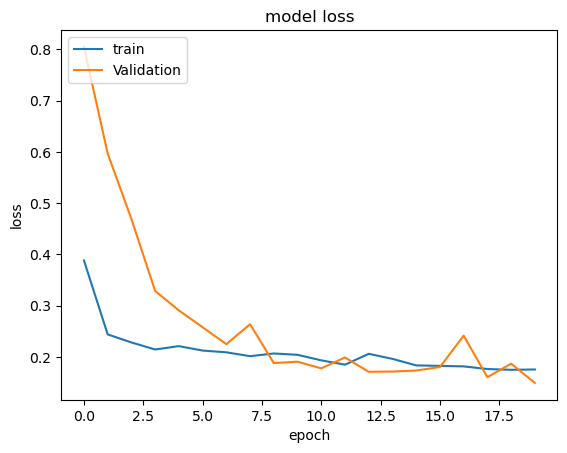

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

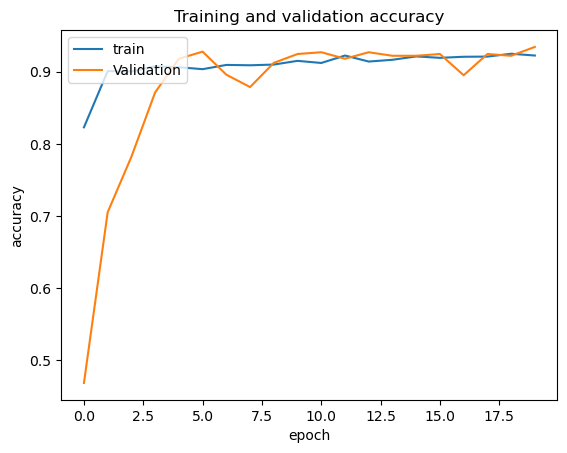

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 7ms/step
[[370 116   5]
 [ 86 446   0]
 [  0   0 537]]
0.8673076923076923
0.866638461448184
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       491
           1       0.79      0.84      0.82       532
           2       0.99      1.00      1.00       537

    accuracy                           0.87      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.87      0.87      1560



<Axes: >

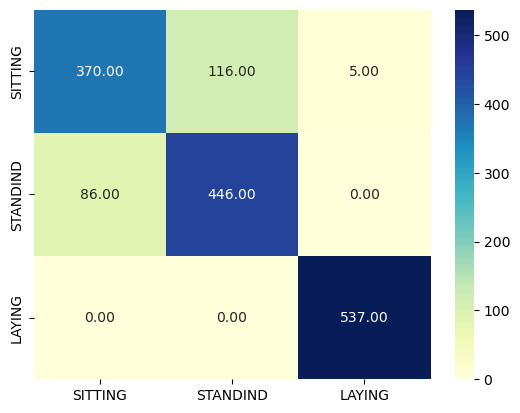

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## BiLSTM1 - BiGRU2

In [24]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128, 128)         37888     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128)         512       
 hNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 256)         198144    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                      

In [25]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/20
32/32 [==============================] - 6s 74ms/step - loss: 0.3550 - accuracy: 0.8480 - val_loss: 0.7187 - val_accuracy: 0.5332
Epoch 2/20
32/32 [==============================] - 1s 46ms/step - loss: 0.2355 - accuracy: 0.8980 - val_loss: 0.5394 - val_accuracy: 0.6749
Epoch 3/20
32/32 [==============================] - 2s 47ms/step - loss: 0.2360 - accuracy: 0.9007 - val_loss: 0.4746 - val_accuracy: 0.7142
Epoch 4/20
32/32 [==============================] - 1s 46ms/step - loss: 0.2245 - accuracy: 0.9012 - val_loss: 0.3535 - val_accuracy: 0.8321
Epoch 5/20
32/32 [==============================] - 1s 47ms/step - loss: 0.2166 - accuracy: 0.9127 - val_loss: 0.2239 - val_accuracy: 0.9328
Epoch 6/20
32/32 [==============================] - 1s 46ms/step - loss: 0.2108 - accuracy: 0.9139 - val_loss: 0.2441 - val_accuracy: 0.9066
Epoch 7/20
32/32 [==============================] - 1s 45ms/step - loss: 0.1985 - accuracy: 0.9098 - val_loss: 0.2396 - val_accuracy: 0.9009
Epoch 8/20
32

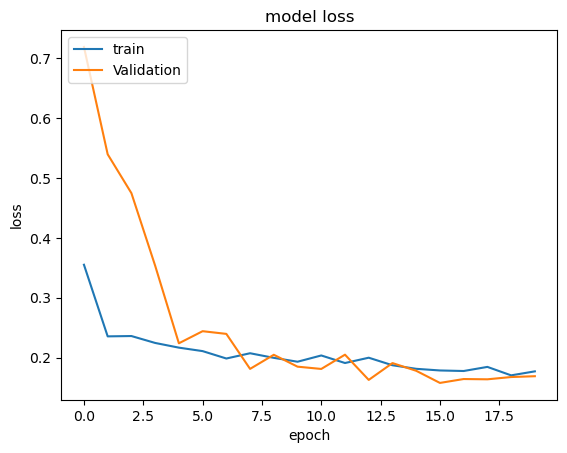

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

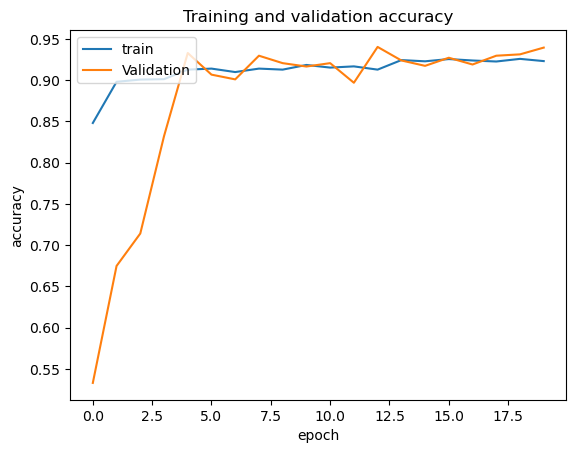

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 11ms/step
[[410  80   1]
 [ 95 437   0]
 [  0   0 537]]
0.8871794871794871
0.8871706546771703
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       491
           1       0.85      0.82      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.89      0.89      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

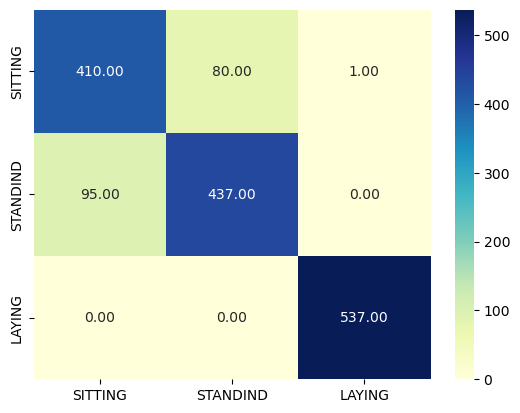

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## BiLSTM2 - BiGRU1

In [29]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 128, 128)         37888     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128, 128)          0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128)         512       
 hNormalization)                                                 
                                                                 
 bidirectional_6 (Bidirectio  (None, 128, 256)         263168    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                      

In [30]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/20
32/32 [==============================] - 6s 81ms/step - loss: 0.3218 - accuracy: 0.8598 - val_loss: 1.0640 - val_accuracy: 0.3546
Epoch 2/20
32/32 [==============================] - 2s 48ms/step - loss: 0.2177 - accuracy: 0.9100 - val_loss: 1.1002 - val_accuracy: 0.4857
Epoch 3/20
32/32 [==============================] - 2s 48ms/step - loss: 0.2051 - accuracy: 0.9132 - val_loss: 0.4781 - val_accuracy: 0.7428
Epoch 4/20
32/32 [==============================] - 2s 48ms/step - loss: 0.2124 - accuracy: 0.9085 - val_loss: 0.3787 - val_accuracy: 0.8010
Epoch 5/20
32/32 [==============================] - 2s 49ms/step - loss: 0.2121 - accuracy: 0.9115 - val_loss: 0.5547 - val_accuracy: 0.8321
Epoch 6/20
32/32 [==============================] - 2s 51ms/step - loss: 0.2054 - accuracy: 0.9103 - val_loss: 0.1973 - val_accuracy: 0.9255
Epoch 7/20
32/32 [==============================] - 2s 48ms/step - loss: 0.1966 - accuracy: 0.9171 - val_loss: 0.3825 - val_accuracy: 0.7912
Epoch 8/20
32

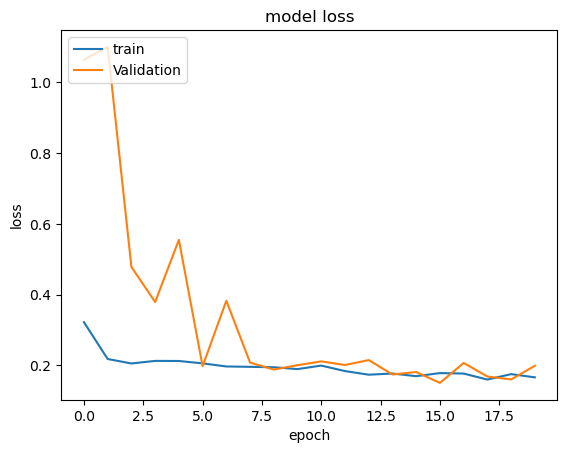

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

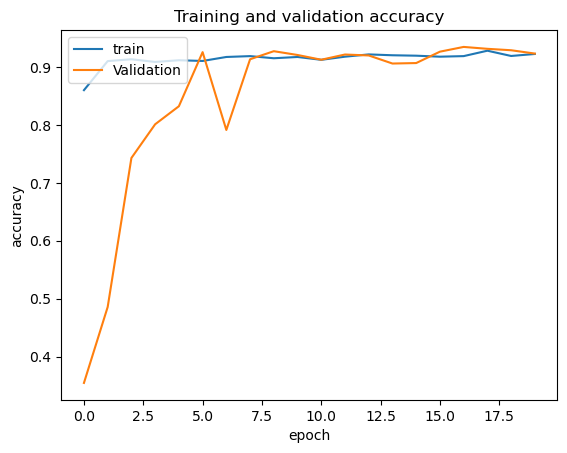

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 13ms/step
[[426  65   0]
 [100 432   0]
 [  0   0 537]]
0.8942307692307693
0.8942519939675438
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       491
           1       0.87      0.81      0.84       532
           2       1.00      1.00      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.89      0.89      1560
weighted avg       0.90      0.89      0.89      1560



<Axes: >

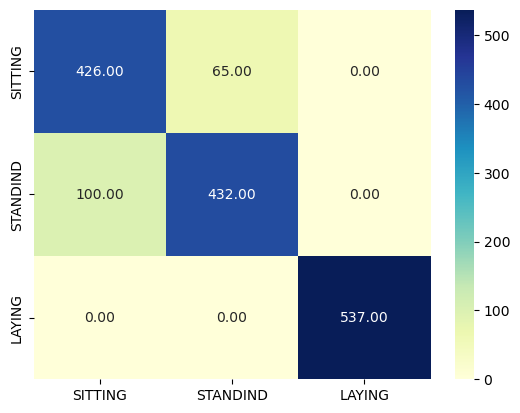

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## BiLSTM2 - BiGRU2

In [34]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 128, 128)         37888     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128)         512       
 hNormalization)                                                 
                                                                 
 bidirectional_9 (Bidirectio  (None, 128, 256)         263168    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128, 256)          0         
                                                      

In [35]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/20
32/32 [==============================] - 8s 101ms/step - loss: 0.3673 - accuracy: 0.8525 - val_loss: 1.4688 - val_accuracy: 0.3481
Epoch 2/20
32/32 [==============================] - 2s 67ms/step - loss: 0.2263 - accuracy: 0.9071 - val_loss: 1.0925 - val_accuracy: 0.5332
Epoch 3/20
32/32 [==============================] - 2s 66ms/step - loss: 0.2161 - accuracy: 0.9112 - val_loss: 1.1210 - val_accuracy: 0.6036
Epoch 4/20
32/32 [==============================] - 2s 64ms/step - loss: 0.2277 - accuracy: 0.9029 - val_loss: 0.5869 - val_accuracy: 0.7486
Epoch 5/20
32/32 [==============================] - 2s 67ms/step - loss: 0.2143 - accuracy: 0.9088 - val_loss: 0.3738 - val_accuracy: 0.8460
Epoch 6/20
32/32 [==============================] - 2s 67ms/step - loss: 0.2001 - accuracy: 0.9171 - val_loss: 0.3296 - val_accuracy: 0.8452
Epoch 7/20
32/32 [==============================] - 2s 68ms/step - loss: 0.2032 - accuracy: 0.9159 - val_loss: 0.2024 - val_accuracy: 0.9206
Epoch 8/20
3

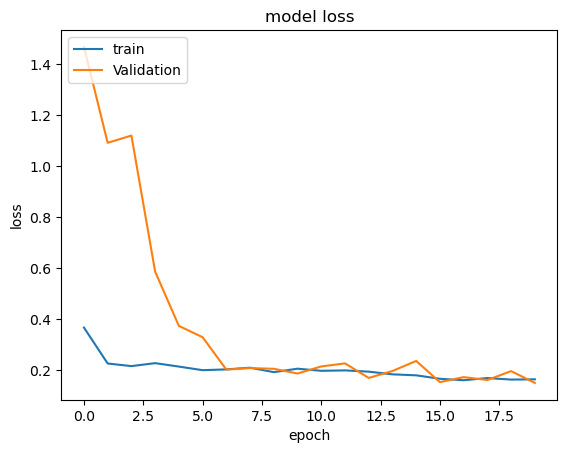

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

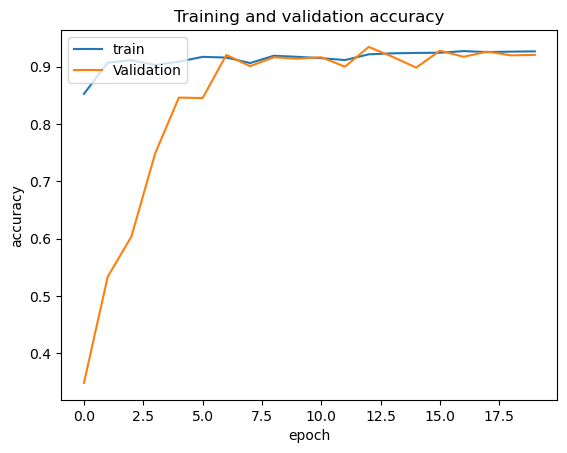

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 16ms/step
[[421  70   0]
 [117 415   0]
 [  0   0 537]]
0.8801282051282051
0.8800959031002377
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       491
           1       0.86      0.78      0.82       532
           2       1.00      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

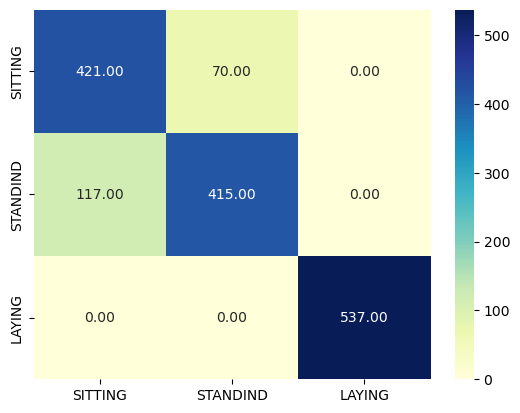

In [38]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')